# Assignment 4

This notebook will explore the Kaggle Competition [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/c/nlp-getting-started). The goal is to use a Recurrent Neural Network to classify tweets depending on whether the tweet is describing an actual distaster or not.

In [100]:
import numpy as np
import pandas as pd
from tensorflow import keras
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import BatchNormalization, TextVectorization, Embedding, Bidirectional, Dense, LSTM, GRU, Dropout
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import nltk
from nltk.corpus import stopwords

In [ ]:
samp_sub = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')
train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

print(len(samp_sub))
print(len(train))
print(len(test))

In [110]:
print(train.info())
print(test.info())
print(samp_sub.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            7613 non-null   int64 
 1   keyword       7552 non-null   object
 2   location      5080 non-null   object
 3   text          7613 non-null   object
 4   target        7613 non-null   int64 
 5   text_split    7613 non-null   object
 6   word_count    7613 non-null   int64 
 7   stop_removed  7613 non-null   object
 8   recombine     7613 non-null   object
dtypes: int64(3), object(6)
memory usage: 535.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            3263 non-null   int64 
 1   keyword       3237 non-null   object
 2   location      2158 non-null   object
 3   text          3263 non-null   object
 4   text_split  

In [7]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## Exploratory Data Analysis

The data for the competition includes two datasets, one training set, and one test set for the Kaggle competition. There is also a sample submission to assist users in generating their submission files. The Training dataset has 7,613 records, while the test dataset has 3,263 records. Both datasets contain a numeric `id` column, a `keyword`, a `location` and the `text` of the tweet. The training set also contains `target`, which represents the true labels of the training data, `0` for a non-disaster, and `1` for a disaster. A small subset of the training dataset is printed above.

In [51]:
stops = stopwords.words('english')

def split_words(df):
    df['text_split'] = [txt.split(' ') for txt in df['text']]
    df['word_count'] = [len(words) for words in df['text_split']]
    df['stop_removed'] = [[word for word in lst if word.lower() not in stops] for lst in df['text_split']]
    df['recombine'] = [' '.join(lst) for lst in df['stop_removed']]

In [52]:
split_words(train)
split_words(test)

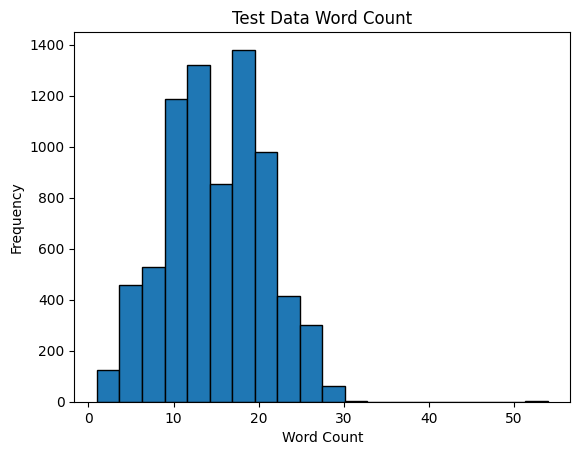

In [54]:
plt.hist(train['word_count'], bins=20, edgecolor='black')

plt.title('Test Data Word Count')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

plt.show()

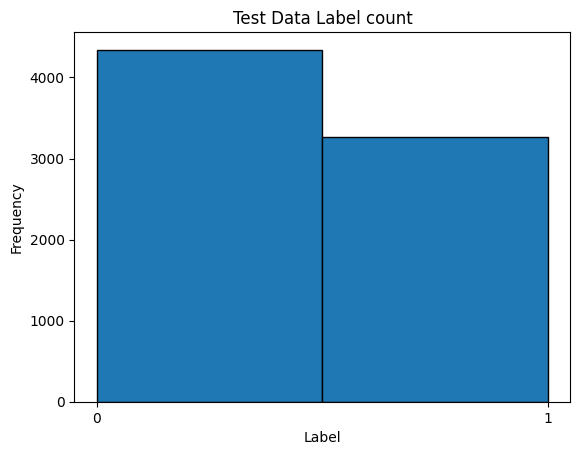

In [55]:
plt.hist(train['target'], bins=2, edgecolor='black')

plt.title('Test Data Label count')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks([0,1])

plt.show()

Some basic analysis shows that most tweets contain about 10-20 words, and there is a slight imbalance, between non-disaster and disaster tweets.

In [56]:
train_pos = train[train['target'] == 1]
train_neg = train[train['target'] == 0]

pos_words = [word for lst in train_pos['text_split'] for word in lst]
neg_words = [word for lst in train_neg['text_split'] for word in lst]
all_words = [word for lst in train['text_split'] for word in lst]

In [38]:
print(len(set(all_words)))

32017


In [30]:
pos_cloud = WordCloud().generate(" ".join(pos_words))
neg_cloud = WordCloud().generate(" ".join(neg_words))
all_cloud = WordCloud().generate(" ".join(all_words))

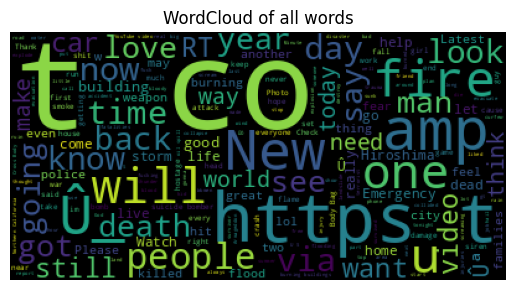

In [32]:
plt.axis("off")
plt.title("WordCloud of all words")
plt.imshow(all_cloud)

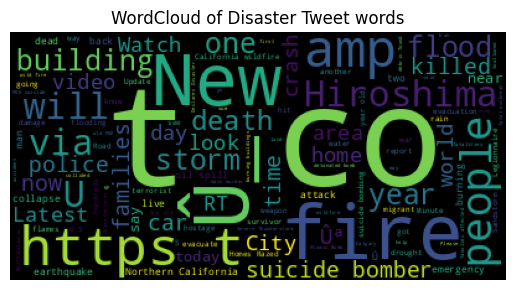

In [33]:
plt.axis("off")
plt.title("WordCloud of Disaster Tweet words")
plt.imshow(pos_cloud)

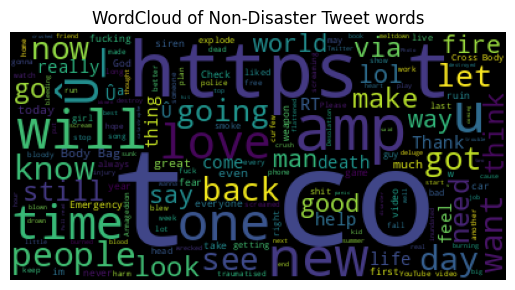

In [34]:
plt.axis("off")
plt.title("WordCloud of Non-Disaster Tweet words")
plt.imshow(neg_cloud)

The above wordclouds offer some perspective on the difference in content between disaster and non-disaster tweets. Both sets contain some similar high-frequency terms, such as `t`, `co`, `https`, and other link segments that appear in tweets in images. Beyond that, there are some differences such as non-disaster tweets containing `lol` or `love`, while disaster tweets include phrases like `suicide bomber` or `Hiroshima`. Unfortunatly, there is a lot of other crossover, such as `fire` or `people`.


## Model Architecture

Because of the significant crossover of words between both disaster and non-disaster tweets, we will need a model that can consider the sequence of the words in the tweets, rather than just the presence or frequency of them. For example, someone responding to a video of a series of pranks might express their joy at the prank victims' reactions with `Everyone's so scared, I'm dead`. Meanwhile, Someone surveying the scene of a disaster might tweet `Everyone's dead, I'm so scared`. The individual word content of the two tweets are the same, but the order of the words reveals the drastic difference in the two situations.

For this reason, we will use an RNN model. RNN architecture allows the sequence of words in a tweet to carry through the training of the model.

In [58]:
X_train, X_test, y_train, y_test = train_test_split(train['recombine'], train['target'], test_size=0.2, random_state=42)

Keras includes the `TextVectorization` layer that can serve as a preprocessor for the text data, reducing the need to do our own preprocessing. There are over 32,000 unique words in the dataset, so it may be helpful to limit the size of the vocabulary. Text standardization will also help to cut down on unnecessary processing of one-off words. The exception is the removal of stopwords, which we have handled ourselves.

In [59]:
encoder = TextVectorization(
    max_tokens=20000, standardize='lower_and_strip_punctuation', split='whitespace')
encoder.adapt(X_train)

In [60]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'like', 'im', 'amp', 'fire', 'get', 'via', 'new',
       'people', 'news', 'one', 'video', 'us', '2', 'emergency',
       'disaster', 'would', 'still', 'body'], dtype='<U52')

Now that we have created our vectorizor, we are ready to build, compile, and train our model. We will start by using a layer with LSTM cells to overcome some of the limitatons of base RNN cells.

In [67]:
model1 = keras.Sequential([
    encoder,
    Embedding(
        #Must be +1 if mask_zero
        input_dim=len(encoder.get_vocabulary()) + 1,
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    Bidirectional(LSTM(64)),
    Dense(64, activation='relu'),
    Dense(1)
])

model1.compile(
    loss=BinaryCrossentropy(from_logits=True),
    optimizer=Adam(1e-4),
    metrics=['accuracy']
)

model1.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization_3                 │ ?                           │     0 (unbuilt) │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_3 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [71]:
m1_hist = model1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20)

Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.6067 - loss: 0.6159 - val_accuracy: 0.7846 - val_loss: 0.4835
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.8717 - loss: 0.3367 - val_accuracy: 0.8024 - val_loss: 0.4865
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9219 - loss: 0.2183 - val_accuracy: 0.7971 - val_loss: 0.5679
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.9508 - loss: 0.1400 - val_accuracy: 0.7814 - val_loss: 0.6820
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9674 - loss: 0.0926 - val_accuracy: 0.7708 - val_loss: 0.8253
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9784 - loss: 0.0636 - val_accuracy: 0.7682 - val_loss: 0.9330
Epoch 7/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9852 - loss: 0.0481 - val_accuracy: 0.7505 - val_loss: 1.0814
Epoch 8/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9910 - loss: 0.0339 - val_accu

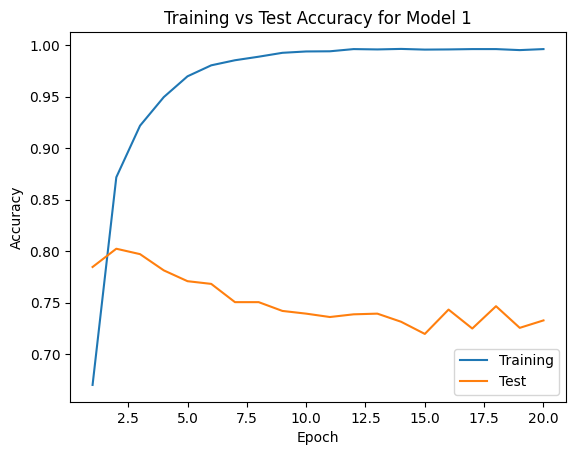

In [74]:
epochs = range(1, 21)
plt.plot(epochs, m1_hist.history['accuracy'], label='Training')
plt.plot(epochs, m1_hist.history['val_accuracy'], label='Test')
plt.title('Training vs Test Accuracy for Model 1')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

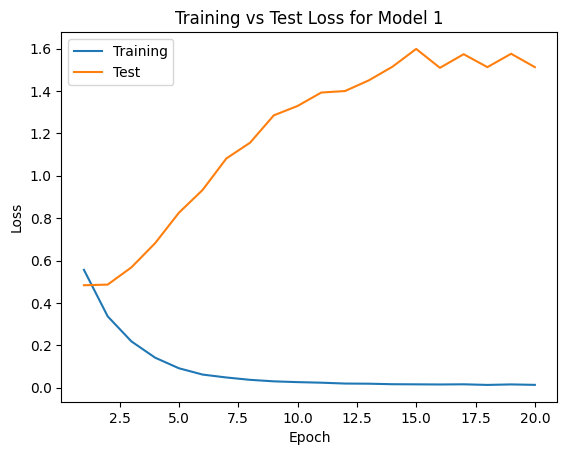

In [75]:
epochs = range(1, 21)
plt.plot(epochs, m1_hist.history['loss'], label='Training')
plt.plot(epochs, m1_hist.history['val_loss'], label='Test')
plt.title('Training vs Test Loss for Model 1')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Initial Results

Both the accuracy and loss plots above very clearly show that the model performed extremely well on the training data after only a few epochs. The downside is that the validation curves show extreme overfitting. The model will be updated in an attempt to correct the overfitting and improve generalization. First, we will do this by adding a dropout layer and setting the batch size

In [78]:
model2 = keras.Sequential([
    encoder,
    Embedding(
        #Must be +1 if mask_zero
        input_dim=len(encoder.get_vocabulary()) + 1,
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    Bidirectional(LSTM(64)),
    Dropout(0.25),
    Dense(64, activation='relu'),
    Dropout(0.25),
    Dense(1)
])

model2.compile(
    loss=BinaryCrossentropy(from_logits=True),
    optimizer=Adam(1e-4),
    metrics=['accuracy']
)

model2.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization_3                 │ (None, None)                │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_5 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [80]:
m2_hist = model2.fit(X_train, y_train, batch_size=32, validation_data=(X_test, y_test), epochs=20)

Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5693 - loss: 0.6917 - val_accuracy: 0.5739 - val_loss: 0.6835
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.5692 - loss: 0.6682 - val_accuracy: 0.6980 - val_loss: 0.5807
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.8388 - loss: 0.3988 - val_accuracy: 0.7814 - val_loss: 0.5084
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.9150 - loss: 0.2499 - val_accuracy: 0.7774 - val_loss: 0.6086
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.9437 - loss: 0.1750 - val_accuracy: 0.7722 - val_loss: 0.7191
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.9639 - loss: 0.1166 - val_accuracy: 0.7695 - val_loss: 0.8976
Epoch 7/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.9738 - loss: 0.0814 - val_accuracy: 0.7656 - val_loss: 1.1514
Epoch 8/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.9828 - loss: 0.0575 - val_acc

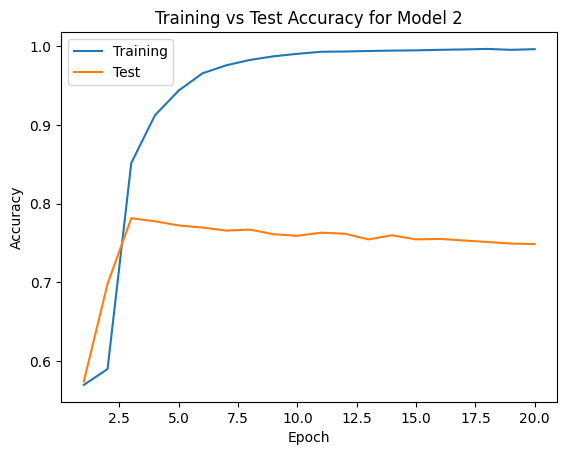

In [81]:
epochs = range(1, 21)
plt.plot(epochs, m2_hist.history['accuracy'], label='Training')
plt.plot(epochs, m2_hist.history['val_accuracy'], label='Test')
plt.title('Training vs Test Accuracy for Model 2')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

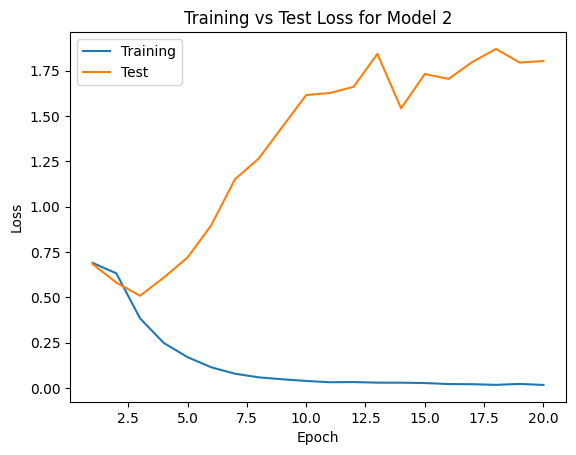

In [82]:
epochs = range(1, 21)
plt.plot(epochs, m2_hist.history['loss'], label='Training')
plt.plot(epochs, m2_hist.history['val_loss'], label='Test')
plt.title('Training vs Test Loss for Model 2')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

The introduction of the dropout layer was not very successful in reducing the overfitting. The next approach will be to add Batch Normalization as well.

In [85]:
model3 = keras.Sequential([
    encoder,
    Embedding(
        #Must be +1 if mask_zero
        input_dim=len(encoder.get_vocabulary()) + 1,
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    Bidirectional(LSTM(64)),
    BatchNormalization(),
    Dropout(0.25),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),
    Dense(1)
])

model3.compile(
    loss=BinaryCrossentropy(from_logits=True),
    optimizer=Adam(1e-4),
    metrics=['accuracy']
)

model3.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization_3                 │ (None, None)                │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_7 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_7 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [86]:
m3_hist = model3.fit(X_train, y_train, batch_size=32, validation_data=(X_test, y_test), epochs=20)

Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.5411 - loss: 0.8770 - val_accuracy: 0.5739 - val_loss: 0.6863
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.6592 - loss: 0.6459 - val_accuracy: 0.5929 - val_loss: 0.6408
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7553 - loss: 0.5043 - val_accuracy: 0.6947 - val_loss: 0.5624
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.8252 - loss: 0.3929 - val_accuracy: 0.7551 - val_loss: 0.5537
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.8779 - loss: 0.3016 - val_accuracy: 0.7485 - val_loss: 0.6576
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.9134 - loss: 0.2179 - val_accuracy: 0.7518 - val_loss: 0.7008
Epoch 7/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.9279 - loss: 0.1744 - val_accuracy: 0.7400 - val_loss: 0.8381
Epoch 8/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.9506 - loss: 0.1313 - val_acc

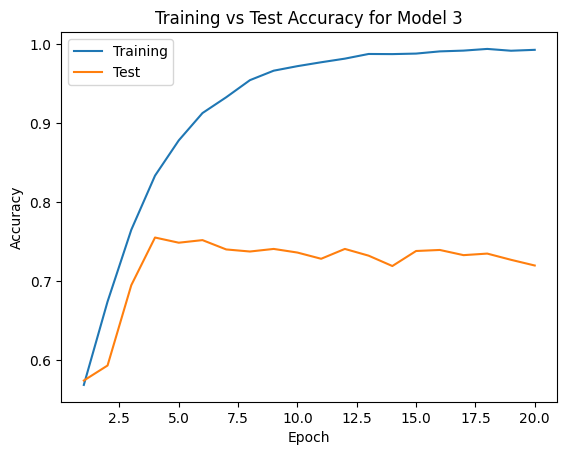

In [87]:
epochs = range(1, 21)
plt.plot(epochs, m3_hist.history['accuracy'], label='Training')
plt.plot(epochs, m3_hist.history['val_accuracy'], label='Test')
plt.title('Training vs Test Accuracy for Model 3')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

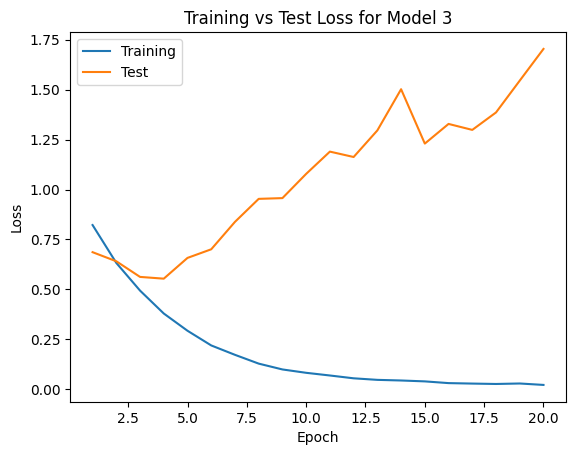

In [88]:
epochs = range(1, 21)
plt.plot(epochs, m3_hist.history['loss'], label='Training')
plt.plot(epochs, m3_hist.history['val_loss'], label='Test')
plt.title('Training vs Test Loss for Model 3')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

Again, it appears we have made some progress towards reducing overfitting, however it is still a major issue with the model. Another attempt will be made with a reduced features.

In [93]:
model4 = keras.Sequential([
    encoder,
    Embedding(
        #Must be +1 if mask_zero
        input_dim=len(encoder.get_vocabulary()) + 1,
        output_dim=16,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    Bidirectional(LSTM(16)),
    BatchNormalization(),
    Dropout(0.25),
    Dense(16, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),
    Dense(1)
])

model4.compile(
    loss=BinaryCrossentropy(from_logits=True),
    optimizer=Adam(1e-4),
    metrics=['accuracy']
)

model4.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization_3                 │ (None, None)                │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_9 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_9 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [94]:
m4_hist = model4.fit(X_train, y_train, batch_size=32, validation_data=(X_test, y_test), epochs=20)

Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.5315 - loss: 0.8657 - val_accuracy: 0.5739 - val_loss: 0.7094
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.6072 - loss: 0.7285 - val_accuracy: 0.6244 - val_loss: 0.7192
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.6559 - loss: 0.6396 - val_accuracy: 0.6697 - val_loss: 0.6721
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.7151 - loss: 0.5653 - val_accuracy: 0.6993 - val_loss: 0.6134
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.7589 - loss: 0.5014 - val_accuracy: 0.7150 - val_loss: 0.5937
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.7988 - loss: 0.4508 - val_accuracy: 0.7360 - val_loss: 0.5625
Epoch 7/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.8391 - loss: 0.3676 - val_accuracy: 0.7374 - val_loss: 0.5691
Epoch 8/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.8711 - loss: 0.3247 - val_acc

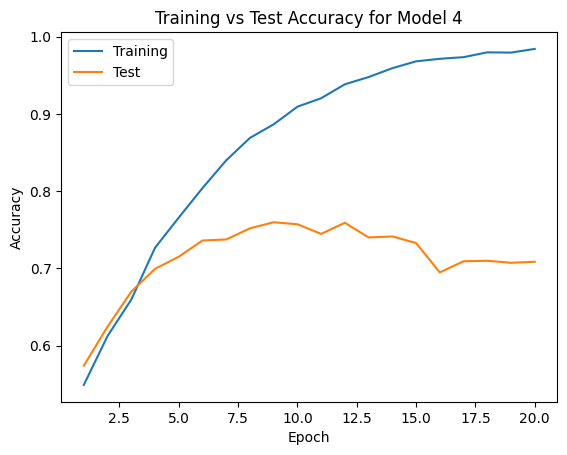

In [95]:
epochs = range(1, 21)
plt.plot(epochs, m4_hist.history['accuracy'], label='Training')
plt.plot(epochs, m4_hist.history['val_accuracy'], label='Test')
plt.title('Training vs Test Accuracy for Model 4')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

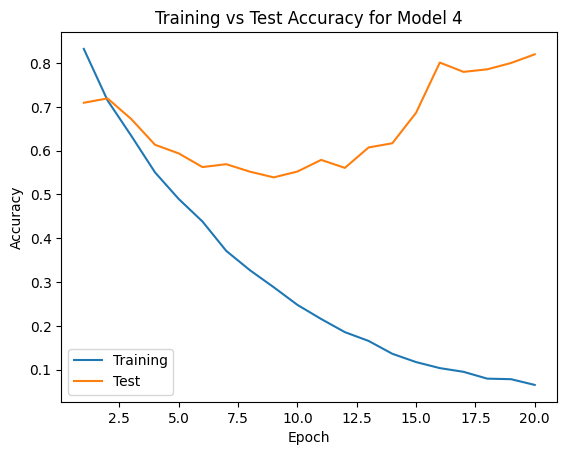

In [96]:
epochs = range(1, 21)
plt.plot(epochs, m4_hist.history['loss'], label='Training')
plt.plot(epochs, m4_hist.history['val_loss'], label='Test')
plt.title('Training vs Test Accuracy for Model 4')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

These updates to the model have continued to have only incremental success in reducing the overfitting. We will try changing away from LSTM cells to GRU cells, to see if there is a difference

In [99]:
model5 = keras.Sequential([
    encoder,
    Embedding(
        #Must be +1 if mask_zero
        input_dim=len(encoder.get_vocabulary()) + 1,
        output_dim=16,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    Bidirectional(GRU(16)),
    BatchNormalization(),
    Dropout(0.25),
    Dense(16, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),
    Dense(1)
])

model5.compile(
    loss=BinaryCrossentropy(from_logits=True),
    optimizer=Adam(1e-4),
    metrics=['accuracy']
)

model5.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization_3                 │ (None, None)                │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_11 (Embedding)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_10 (Bidirectional)     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [101]:
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10,        
    mode='min',         
    restore_best_weights=True 
)
m5_hist = model5.fit(X_train, y_train, callbacks=[early_stopping], batch_size=32, validation_data=(X_test, y_test), epochs=20)

Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.5287 - loss: 0.9250 - val_accuracy: 0.4261 - val_loss: 0.7960
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.5940 - loss: 0.7778 - val_accuracy: 0.4380 - val_loss: 0.8617
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.6522 - loss: 0.6687 - val_accuracy: 0.6264 - val_loss: 0.6998
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.6801 - loss: 0.6312 - val_accuracy: 0.6651 - val_loss: 0.6387
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.7239 - loss: 0.5534 - val_accuracy: 0.6888 - val_loss: 0.5997
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.7588 - loss: 0.5050 - val_accuracy: 0.7131 - val_loss: 0.5796
Epoch 7/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.8052 - loss: 0.4360 - val_accuracy: 0.7301 - val_loss: 0.5634
Epoch 8/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.8117 - loss: 0.4108 - val_acc

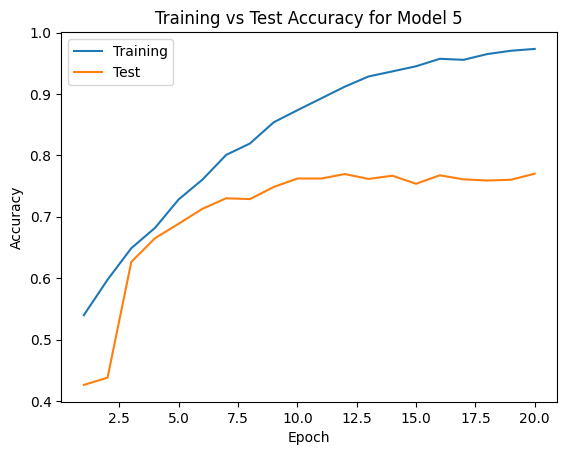

In [102]:
epochs = range(1, 21)
plt.plot(epochs, m5_hist.history['accuracy'], label='Training')
plt.plot(epochs, m5_hist.history['val_accuracy'], label='Test')
plt.title('Training vs Test Accuracy for Model 5')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

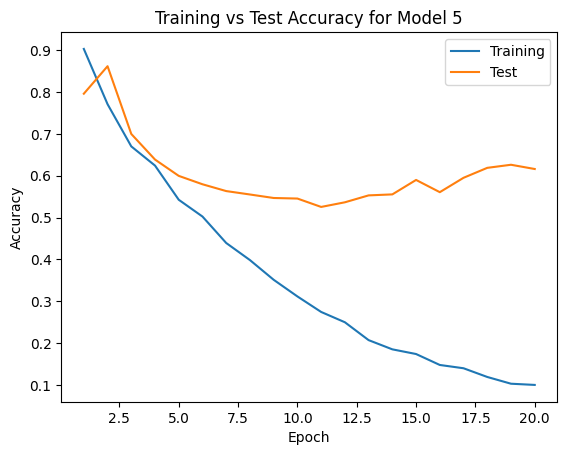

In [103]:
epochs = range(1, 21)
plt.plot(epochs, m5_hist.history['loss'], label='Training')
plt.plot(epochs, m5_hist.history['val_loss'], label='Test')
plt.title('Training vs Test Accuracy for Model 5')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Final results

Our fifth model appears to have done the best job so far at reducing the overfitting, however there are still clear signs of it. We will use this model to generate the Kaggle Competition Submission, as it appears to be the most generalizable.

### Accuracy Scores
|Model|Training Accuracy|Test Accuracy|
|-----|-----------------|-------------|
|1|0.9956|0.7328|
|2|0.9956|0.7485|
|3|0.9945|0.7196|
|4|0.9863|0.7085|
|5|0.9722|0.7702|

In [104]:
predictions = model5.predict(test['recombine'], batch_size=32)

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


In [108]:
predict_label = np.where(predictions > 0, 1, 0)

In [112]:
submission = pd.DataFrame({'id': test['id'], 'target': predict_label.flatten()})

In [114]:
submission.head()
submission.to_csv('/kaggle/working/submission.csv')